# Fourier Neural Operator for the Burgers' Equation

### Introduction

In this notebook, we explore the application of Fourier Neural Operators (FNO) to the well-known 1-dimensional Burgers' equation. The Burgers' equation is a non-linear partial differential equation (PDE) with applications in modeling one-dimensional flow of viscous fluid. The equation is given by:

$$ \partial_tu(x, t) + \partial_x(u^2(x, t)/2) = \nu\partial_{xx}u(x, t)$$
where $x \in (0, 1)$, $t \in (0, 1)$ and $u(x, 0) = u_0(x)$ as the initial condition. 

The equation exhibits properties like shock waves and has been a model of interest in fluid dynamics and turbulence.

### Objective

Given the initial condition $u_0 \in L^2((0, 1); \mathbb{R})$ and the viscosity coefficient $\nu$, our aim is to leverage the capabilities of the Fourier Neural Operator to learn the operator mapping the initial condition to its solution at any time $t$. In other words, we're interested in predicting the solution of the Burgers' equation for different initial conditions using deep learning.

### Approach

1. **Data Preparation**: We'll be using the dataset 'burgers_data_R10.mat', which provides us with different initial conditions and their respective solutions.
2. **Model**: The Fourier Neural Operator (FNO) will serve as our model, which utilizes the Fourier transform to operate in the frequency domain, providing both computational efficiency and accuracy.
3. **Training and Evaluation**: We will train our FNO model on the dataset and evaluate its performance against ground truth solutions.

By the end of this notebook, we aim to have a trained FNO model that can predict the Burgers' equation solution with high accuracy.

Let's dive in!

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import numpy as np
import scipy.io
import h5py
import operator
from functools import reduce
import matplotlib.pyplot as plt
import time
from timeit import default_timer
import scipy
import gdown

output = 'burgers_data_R10.mat'  # Change the extension to .zip (or whatever the actual extension is)

# Only download if the file doesn't exist
if not os.path.exists(output):
    url = 'https://drive.google.com/uc?export=download&id=1UsGPoCe8vXbLtD8tS2Azr88s8s-ZFJwr'
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists, skipping download.")

burgers_data_R10.mat already exists, skipping download.


# Plot the dataset


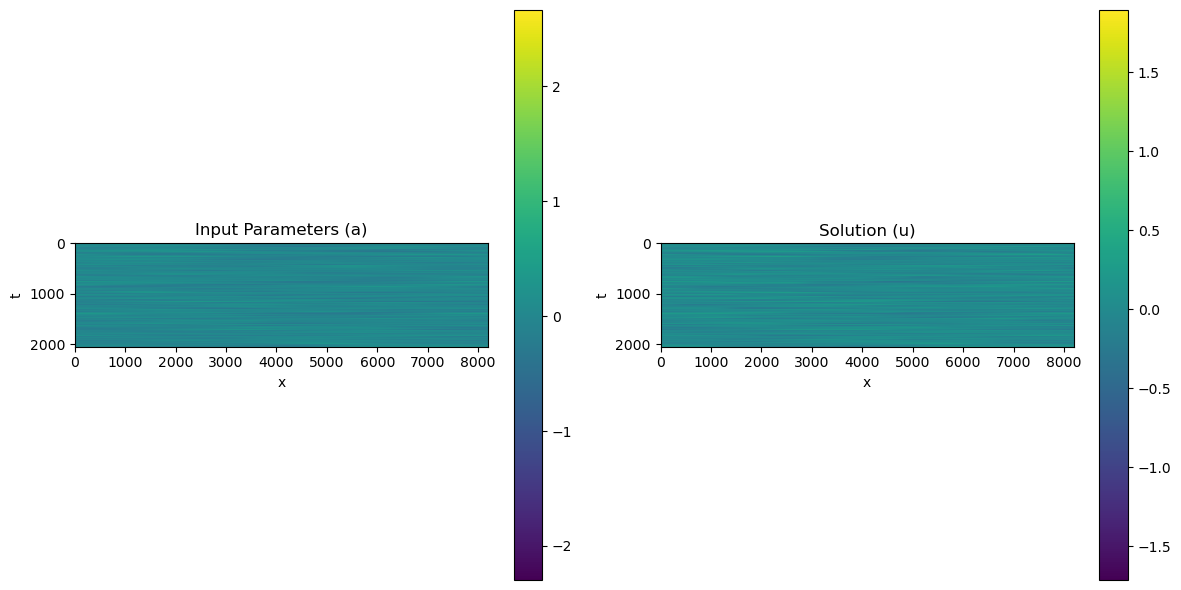

In [2]:
# Load the data
data = scipy.io.loadmat('burgers_data_R10.mat')

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 'a' - the input parameters
cax1 = ax1.imshow(data['a'])
ax1.set_title('Input Parameters (a)')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
fig.colorbar(cax1, ax=ax1)

# Plot 'u' - the solution
cax2 = ax2.imshow(data['u'])
ax2.set_title('Solution (u)')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
fig.colorbar(cax2, ax=ax2)

# Adjust layout
plt.tight_layout()
plt.show()


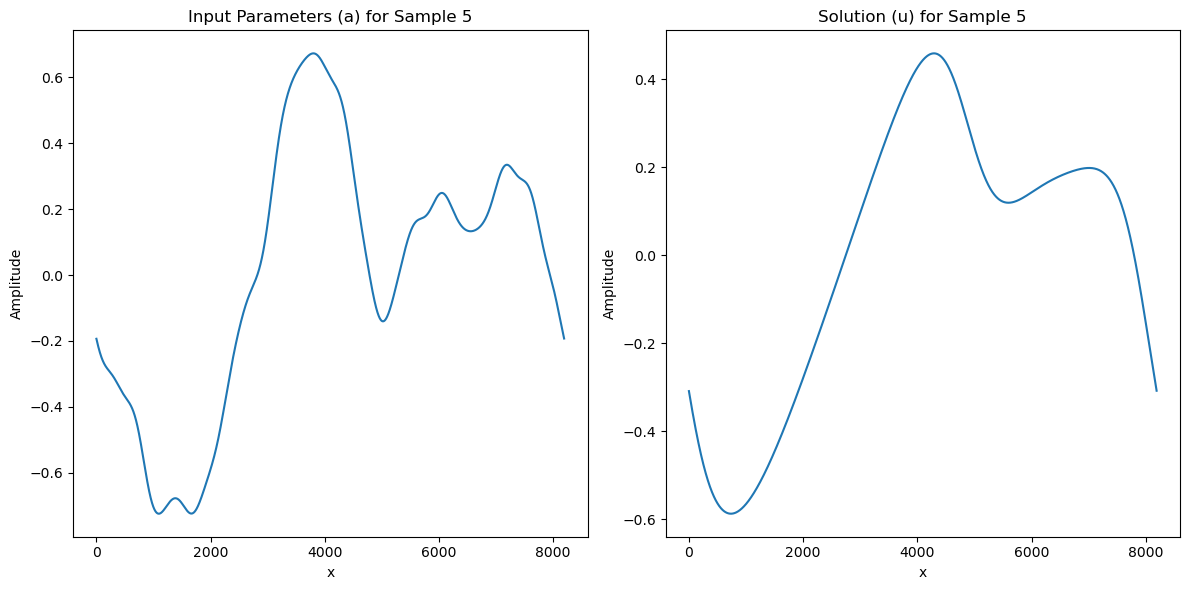

In [3]:
# Load the data
data = scipy.io.loadmat('burgers_data_R10.mat')

# Choose a specific sample index
sample_index = 5

# Extract the specific sample from data
input_sample = data['a'][sample_index]
solution_sample = data['u'][sample_index]

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the input sample
ax1.plot(input_sample)
ax1.set_title(f'Input Parameters (a) for Sample {sample_index}')
ax1.set_xlabel('x')
ax1.set_ylabel('Amplitude')

# Plot the solution sample
ax2.plot(solution_sample)
ax2.set_title(f'Solution (u) for Sample {sample_index}')
ax2.set_xlabel('x')
ax2.set_ylabel('Amplitude')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Setup our training device

In [4]:
def test_fft(device):
    try:
        x = torch.rand(16, device=device)
        _ = torch.fft.rfft(x)
        return True
    except NotImplementedError:
        return False

if torch.cuda.is_available():
    device = torch.device("cuda")
    if not test_fft(device):
        print("FFT not supported on CUDA. Switching to CPU.")
        device = torch.device("cpu")
    else:
        print("Using CUDA.")

elif torch.backends.mps.is_available():
    device = torch.device("mps")
    if not test_fft(device):
        print("FFT not supported on MPS. Switching to CPU.")
        device = torch.device("cpu")
    else:
        print("Using MPS.")

else:
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")
    print("Using CPU.")


FFT not supported on MPS. Switching to CPU.


In [5]:
class MatReader:
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        """
        Initialize a MatReader object.
        
        :param file_path: Path to the .mat file.
        :param to_torch: Convert numpy arrays to PyTorch tensors.
        :param to_cuda: Move tensors to GPU.
        :param to_float: Convert data to float type.
        """
        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.data = self._load_file(file_path)

    def _load_file(self, file_path):
        """
        Load the .mat file.
        
        :param file_path: Path to the .mat file.
        """
        try:
            data = scipy.io.loadmat(file_path)
            old_mat = True
        except NotImplementedError:
            data = h5py.File(file_path, 'r')
            old_mat = False

        return {'data': data, 'old_mat': old_mat}

    def read_field(self, field):
        """
        Read the specified field from the .mat file.
        
        :param field: Name of the field to read.
        """
        x = self.data['data'][field]

        if not self.data['old_mat']:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)
            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        """Set the to_cuda flag."""
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        """Set the to_torch flag."""
        self.to_torch = to_torch

    def set_float(self, to_float):
        """Set the to_float flag."""
        self.to_float = to_float


In [6]:
class LpLoss:
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Assert d and p are positive
        if d <= 0 or p <= 0:
            raise ValueError("Dimension and Lp-norm must be positive")

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def _compute_norm(self, x, y):
        """Helper function to compute the norm."""
        num_examples = x.size(0)
        h = 1.0 / (x.size(1) - 1.0)
        
        x = x.reshape(num_examples, -1)
        y = y.reshape(num_examples, -1)

        return h**(self.d / self.p) * torch.norm(x - y, self.p, dim=1)

    def abs(self, x, y):
        all_norms = self._compute_norm(x, y)
        return self._reduction(all_norms)

    def rel(self, x, y):
        num_examples = x.size(0)
        diff_norms = self._compute_norm(x, y)
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, dim=1)
        return self._reduction(diff_norms / y_norms)

    def _reduction(self, norms):
        """Helper function to apply reduction."""
        if self.reduction:
            return torch.mean(norms) if self.size_average else torch.sum(norms)
        return norms

    def __call__(self, x, y):
        return self.rel(x, y)


In [7]:
# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size()))
    return c

# Neural Operator

The Neural Operator, proposed by [Li et al., 2020](https://arxiv.org/abs/2003.03485), offers a novel approach to function approximation challenges. Let's dive into the architecture and principles behind this innovative technique.

## Definition and Formulation

The Neural Operator is conceived as an iterative sequence, illustrated as $ v_0 \mapsto v_1 \mapsto \ldots \mapsto v_T $, where each $ v_j $ for $ j = 0, 1, \ldots, T - 1 $ represents a series of functions that take values in $ \mathbb{R}^{d_v} $.

The procedure begins with the input $ a \in A $ being elevated to a superior dimensional representation through:

$$ v_0(x) = P(a(x)) $$

This is achieved by the local transformation $ P $, typically realized using a shallow, fully-connected neural network.

Subsequent steps involve several iterations of updates from $ v_t $ to $ v_{t+1} $. The final output, $ u(x) = Q(v_T(x)) $, emerges as a projection of $ v_T $ by a local transformation defined as:

$$ Q : \mathbb{R}^{d_v} \rightarrow \mathbb{R}^{d_u} $$

Each iteration is characterized by a combination of a non-local integral operator $ K $ and a local, nonlinear activation function $ \sigma $.

### Iterative Updates

The transformation from $ v_t $ to $ v_{t+1} $ is formally represented as:

$$ v_{t+1}(x) = \sigma \left( W v_t(x) + K(a; \phi) v_t(x) \right) $$

Where:

- $ K : A \times \Theta_K \rightarrow L(U(D; \mathbb{R}^{d_v}), U(D; \mathbb{R}^{d_v})) $ maps to bounded linear operators on $ U(D; \mathbb{R}^{d_v}) $ and is parameterized by $ \phi \in \Theta_K $.
- $ W : \mathbb{R}^{d_v} \rightarrow \mathbb{R}^{d_v} $ is a linear transformation.
- $ \sigma : \mathbb{R} \rightarrow \mathbb{R} $ is a nonlinear activation function operating component-wise.

### Kernel Integral Operator

The kernel integral operator in the update process is defined as:

$$\big(K(a; \phi) v_t \big)(x) := \int_D \kappa(x, y, a(x), a(y); \phi) v_t(y) \, dy, \forall x \in D$$
where $k_{\phi}: \mathbb{R}^{2(d+d_a)} \to \mathbb{R}^{d_v \times d_v}$ is a neural network parameterized by $\phi \in \Theta_K$.


## Fourier Neural Operator
We propose replacing the kernel integral operator in (3), by a convolution operator defined in Fourier space. Let $ F $ denote the Fourier transform of a function $ f : D \rightarrow \mathbb{R}^{d_v} $ and $ F^{-1} $ its inverse, then
\begin{align}
(Ff)_j(k) &= \int_D f_j(x) e^{-2i\pi \langle k, x \rangle} \, dx \\ 
(F^{-1}f)_j(x) &= \int_D f_j(k) e^{2i\pi \langle k, x \rangle} \, dk
\end{align}
for $ j = 1, \ldots, d_v $, where $ i = \sqrt{-1} $ is the imaginary unit. By letting $ \kappa_\phi(x, y, a(x), a(y)) = \kappa_\phi(x-y) $ in (3) and applying the convolution theorem, we find that
$$
\big(K(a; \phi) v_t\big)(x) = F^{-1}\left(F(\kappa_\phi) \cdot F(v_t)\right)(x), \forall x \in D.
$$
We, therefore, propose to directly parameterize $ \kappa_\phi $ in Fourier space.

**Fourier integral operator $ K $**
Define the Fourier integral operator
$$
\big(K(\phi) v_t\big) (x) = F^{-1}\left( R_\phi \cdot (Fv_t)\right)(x), \forall x \in D
$$
where $ R_\phi $ is the Fourier transform of a periodic function $ \kappa : \bar{D} \rightarrow \mathbb{R}^{d_v \times d_v} $ parameterized by $ \phi \in \Theta_K $.

For frequency mode $ k \in D $, we have $ (Fv_t)(k) \in \mathbb{C}^{d_v} $ and $ R_\phi(k) \in \mathbb{C}^{d_v \times d_v} $. Notice that since we assume $ \kappa $ is periodic, it admits a Fourier series expansion, so we may work with the discrete modes $ k \in \mathbb{Z}^d $. We pick a finite-dimensional parameterization by truncating the Fourier series at a maximal number of modes $ k_{\text{max}} = \left|\mathbb{Z}_{k_{\text{max}}} \right| = \left| \left\{ k \in \mathbb{Z}^d : |k_j| \leq k_{\text{max},j}, \text{ for } j = 1, \ldots, d \right\} \right| $. We thus parameterize $ R_\phi $ directly as complex-valued $ (k_{\text{max}} \times d_v \times d_v)$-tensor comprising a collection of truncated Fourier modes and therefore drop $ \phi $ from our notation. Since $ \kappa $ is real-valued, we impose conjugate symmetry. We note that the set $ \mathbb{Z}_{k_{\text{max}}} $ is not the canonical choice for the low frequency modes of $ v_t $. Indeed, the low frequency modes are usually defined by placing an upper-bound on the $\ell_1$-norm of $ k \in \mathbb{Z}^d $. We choose $ \mathbb{Z}_{k_{\text{max}}} $ as above since it allows for an efficient implementation.


## Explanation of `SpectralConv1d` and `FNO1d` Classes

### SpectralConv1d

`SpectralConv1d` is a 1-dimensional convolution layer that operates in the Fourier space.

- **Attributes**:
    - `in_channels`: The number of input channels.
    - `out_channels`: The number of output channels.
    - `modes1`: Number of Fourier modes to multiply. This defines the number of frequencies that the layer works with.
    - `scale`: A scaling factor used for initialization.
    - `weights1`: Weights for the convolution in the Fourier space.

- **Methods**:
    - `compl_mul1d`: Computes the complex multiplication between the input tensor and the weights. It uses the `torch.einsum` function for this purpose.
    - `forward`: Defines the forward pass for the layer. It transforms the input to the Fourier space using `torch.fft.rfft`, performs convolution using the defined weights in the Fourier domain, and then transforms the output back to the time domain using `torch.fft.irfft`.

### FNO1d

`FNO1d` stands for Fourier Neural Operator in 1D. This class defines the entire neural network model.

- **Attributes**:
    - `modes1`: Number of Fourier modes.
    - `width`: Width of the hidden layers.
    - `fc0`: A linear layer used to lift the input to the desired channel dimension.
    - `convs`: A list of `SpectralConv1d` layers.
    - `ws`: A list of 1x1 convolution layers. These layers essentially act as pointwise scaling operations.
    - `fc1`, `fc2`: Two linear layers at the end of the network.

- **Methods**:
    - `forward`: Defines the forward pass for the model. It first lifts the input using `fc0`, then applies each of the `SpectralConv1d` layers and the 1x1 convolution layers iteratively. After the convolution operations, the tensor is passed through the two linear layers to produce the final output.

This network essentially integrates spatial information using Fourier transformations and allows for a unique kind of convolution operation in the frequency domain. This can be particularly useful for problems where global (or long-range) interactions are crucial.



The given model, `FNO1d`, is a Fourier Neural Operator for 1-dimensional data. Here's a mathematical breakdown of its operations:

1. **Fourier Neural Operator (FNO)**:
    The primary innovation of FNO is to perform convolutions in the Fourier space, leveraging the fact that convolution in the spatial domain becomes multiplication in the Fourier domain.

2. **SpectralConv1d**:
    Given an input $ x $ with shape `[batch_size, width, spatial_dim]`, it computes the 1D Fast Fourier Transform (FFT) of $ x $ to get `x_ft`. Then, `x_ft` is multiplied with learned Fourier modes (`weights1`) using the function `compl_mul1d`. This is effectively a convolution operation performed in the Fourier domain. The result is then transformed back to the spatial domain using the Inverse FFT to get the output.

   Mathematically, for each channel:
   $$ x_{\text{ft}} = \mathcal{F}(x) $$
   $$ \text{out}_{\text{ft}} = x_{\text{ft}} \odot \text{weights1} $$
   $$ \text{output} = \mathcal{F}^{-1}(\text{out}_{\text{ft}}) $$
   
   where $ \mathcal{F} $ is the Fourier transform, $ \odot $ is the element-wise multiplication, and $ \mathcal{F}^{-1} $ is the inverse Fourier transform.

3. **FNO1d**:
    - Initial Transformation: The input $ x $ first undergoes a linear transformation (`fc0`) to match the desired width.
    - Convolutions in Fourier Space: The transformed input then passes through a series of Fourier convolutions (`convs`) and pointwise convolutions (`ws`). After each convolution pair, a ReLU activation function is applied.
    - Final Transformation: The output from the convolutional layers is then processed through two fully connected layers (`fc1` and `fc2`), with a ReLU activation applied after the first one.

   Overall, the model can be represented as:
   $$ x' = \text{fc0}(x) $$
   $$ x'' = \text{ReLU}\left(\text{SpectralConv1d}(x') + \text{PointwiseConv}(x')\right) $$ (repeated 4 times)
   $$ x''' = \text{ReLU}(\text{fc1}(x'')) $$
   $$ \text{output} = \text{fc2}(x''') $$

The advantage of this approach is that it can approximate operators from infinite-dimensional function spaces using only a finite number of Fourier modes, making it efficient and scalable for various problems, especially in partial differential equations.

In [8]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width)
        
        self.convs = nn.ModuleList([SpectralConv1d(self.width, self.width, self.modes1) for _ in range(4)])
        self.ws = nn.ModuleList([nn.Conv1d(self.width, self.width, 1) for _ in range(4)])
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        for conv, w in zip(self.convs, self.ws):
            x1 = conv(x)
            x2 = w(x)
            x = x1 + x2
            x = F.relu(x)

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [9]:
def load_data(file_name, ntrain, ntest, sub, s, grid_size):
    dataloader = MatReader(file_name)
    x_data = dataloader.read_field('a')[:, ::sub]
    y_data = dataloader.read_field('u')[:, ::sub]

    x_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]

    grid_all = np.linspace(0, 1, grid_size).reshape(grid_size, 1).astype(np.float64)
    grid = torch.tensor(grid_all[::sub, :], dtype=torch.float)
    x_train = torch.cat([x_train.reshape(ntrain, s, 1), grid.repeat(ntrain, 1, 1)], dim=2)
    x_test = torch.cat([x_test.reshape(ntest, s, 1), grid.repeat(ntest, 1, 1)], dim=2)
    return x_train, y_train, x_test, y_test

################################################################
# configurations
################################################################

CONFIG = {
    'train_data_res': 128,
    'save_index': 0,
    'ntrain': 1000,
    'ntest': 200,
    's': 128,
    'sub': 2**13 // 128,
    'batch_size': 50,
    'learning_rate': 0.001,
    'epochs': 10,
    'step_size': 100,
    'gamma': 0.5,
    'modes': 8,
    'width': 128,
    'file_name': 'burgers_data_R10.mat',
    'grid_size': 2**13
}

x_train, y_train, x_test, y_test = load_data(CONFIG['file_name'], CONFIG['ntrain'], CONFIG['ntest'], 
                                             CONFIG['sub'], CONFIG['s'], CONFIG['grid_size'])
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), 
                                           batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), 
                                          batch_size=CONFIG['batch_size'], shuffle=False)

model = FNO1d(CONFIG['modes'], CONFIG['width']).to(device)
print(f'The model has {count_params(model)} trainable parameters')

def compute_loss(model_output, true_values):
    """Computes the mean squared and L2 loss between the model output and true values."""
    mse_loss = F.mse_loss(model_output, true_values, reduction='mean')
    l2_loss = myloss(model_output, true_values)
    return mse_loss, l2_loss

def log_training(epoch, time_elapsed, train_mse, train_l2, test_l2):
    """Logs training information."""
    print(f"Epoch: {epoch}, time: {time_elapsed:.3f}, Train MSE: {train_mse:.3e}, Train L2: {train_l2:.4f}, Test L2: {test_l2:.4f}")


def train_epoch(model, loader, optimizer):
    model.train()
    mse_total, l2_total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x).view(CONFIG['batch_size'], -1)
        y = y.view(CONFIG['batch_size'], -1)
        mse, l2 = compute_loss(out, y)
        mse.backward()
        optimizer.step()
        mse_total += mse.item()
        l2_total += l2.item()
    return mse_total, l2_total

def test_epoch(model, loader):
    model.eval()
    l2_total = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x).view(CONFIG['batch_size'], -1)
            y = y.view(CONFIG['batch_size'], -1)
            _, l2 = compute_loss(out, y)
            l2_total += l2.item()
    return l2_total


################################################################
# Training and Evaluation
################################################################

optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=CONFIG['step_size'], gamma=CONFIG['gamma'])

start_time = time.time()
myloss = LpLoss(size_average=False)

for ep in range(CONFIG['epochs']):
    epoch_start = time.time()  # Start timing the epoch
    
    train_mse, train_l2 = train_epoch(model, train_loader, optimizer)
    test_l2 = test_epoch(model, test_loader)
    scheduler.step()

    train_mse_avg = train_mse / len(train_loader)
    train_l2_avg = train_l2 / CONFIG['ntrain']
    test_l2_avg = test_l2 / CONFIG['ntest']

    epoch_end = time.time()  # End timing the epoch
    log_training(ep, epoch_end - epoch_start, train_mse_avg, train_l2_avg, test_l2_avg)


elapsed = time.time() - start_time
print(f"\n=============================")
print(f"Training done...")
print(f'Training time: {elapsed:.3f} seconds.')
print("=============================\n")

The model has 607361 trainable parameters
Epoch: 0, time: 4.200, Train MSE: 6.894e-02, Train L2: 0.0039, Test L2: 0.0013
Epoch: 1, time: 4.296, Train MSE: 4.076e-03, Train L2: 0.0010, Test L2: 0.0006
Epoch: 2, time: 4.204, Train MSE: 9.491e-04, Train L2: 0.0005, Test L2: 0.0004
Epoch: 3, time: 4.236, Train MSE: 4.770e-04, Train L2: 0.0003, Test L2: 0.0003
Epoch: 4, time: 4.287, Train MSE: 4.390e-04, Train L2: 0.0003, Test L2: 0.0002
Epoch: 5, time: 4.331, Train MSE: 3.614e-04, Train L2: 0.0003, Test L2: 0.0004
Epoch: 6, time: 4.249, Train MSE: 4.808e-04, Train L2: 0.0003, Test L2: 0.0004
Epoch: 7, time: 4.306, Train MSE: 4.811e-04, Train L2: 0.0004, Test L2: 0.0003
Epoch: 8, time: 4.188, Train MSE: 3.699e-04, Train L2: 0.0003, Test L2: 0.0002
Epoch: 9, time: 4.127, Train MSE: 3.094e-04, Train L2: 0.0003, Test L2: 0.0003

Training done...
Training time: 42.424 seconds.



## Analysis of the Neural Operator


## Analysis of the Fourier Neural Operator

- Repeat FFT and iFFT operations per layer.


Possible improvements
- Use a single FFT and iFFT operation for the entire network.
- Modify the loss function to include physics-informed loss



Notes
- Account for relative errors? The plots below show absolute errors, sorted, but maybe pay attention to relative errors as well.

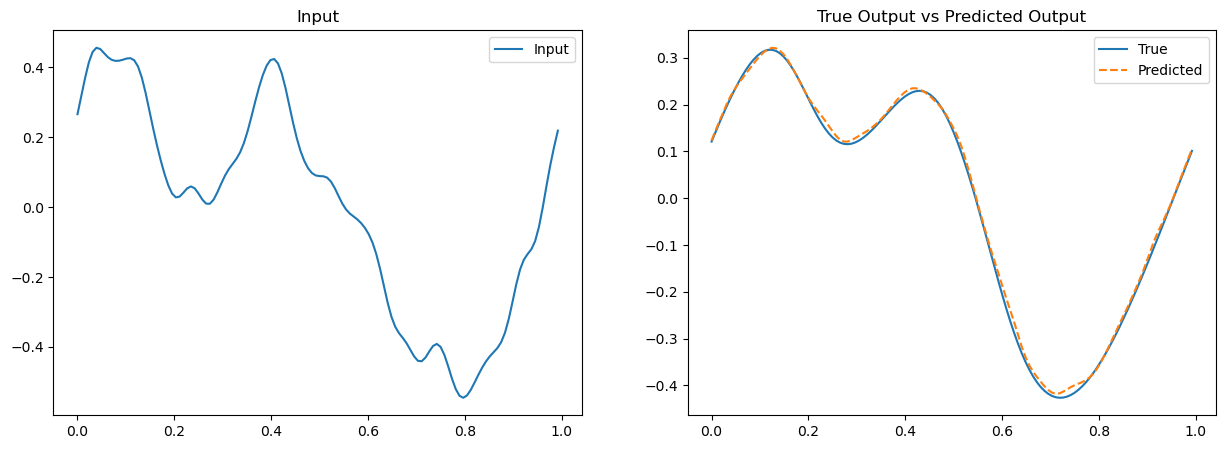

In [10]:
import matplotlib.pyplot as plt

def evaluate_model(model, x):
    """Evaluate the model on test data and return the predictions."""
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        out = model(x)
        return out.cpu()

def plot_example(idx, x_test, y_test, model):
    """Plot the input, true output, and predicted output for a given index."""
    x = x_test[idx:idx+1, :]
    y_true = y_test[idx].numpy()
    y_pred = evaluate_model(model, x).view(-1).numpy()

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Input plot
    ax[0].plot(x[0, :, 1].numpy(), x[0, :, 0].numpy(), label='Input')
    ax[0].set_title('Input')
    ax[0].legend()

    # True vs. Predicted output plot
    ax[1].plot(x[0, :, 1].numpy(), y_true, label='True')
    ax[1].plot(x[0, :, 1].numpy(), y_pred, label='Predicted', linestyle='dashed')
    ax[1].set_title('True Output vs Predicted Output')
    ax[1].legend()

    plt.show()

def compute_errors(model, x_test, y_test):
    """Compute the MSE errors for all samples in the test set."""
    y_preds = evaluate_model(model, x_test)
    y_preds = y_preds.view(y_test.shape)
    if y_preds.shape != y_test.shape:
        raise ValueError(f"Shape mismatch: Predictions shape {y_preds.shape} doesn't match true output shape {y_test.shape}")
    errors = ((y_preds - y_test) ** 2).mean(dim=1).squeeze().numpy()
    return errors

# Compute the errors and get the indices that would sort them in descending order
errors = compute_errors(model, x_test, y_test)
sorted_indices = np.argsort(errors)[::-1]

def plot_sorted_example(rank, x_test, y_test, sorted_indices, model):
    """Plot the input, true output, and predicted output for a given rank."""
    idx = sorted_indices[rank]
    plot_example(idx, x_test, y_test, model)

# Example: plot the test sample with the worst prediction
plot_sorted_example(199, x_test, y_test, sorted_indices, model)


In [14]:
dataloader = MatReader('burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:, ::10]
y_data = dataloader.read_field('u')[:, ::10]

In [13]:
x_data = scipy.io.loadmat('burgers_data_R10.mat')['a'][:, ::10]
x_data = scipy.io.loadmat('burgers_data_R10.mat')['u'][:, ::10]
